This is a starter file of network simulation

## Import the required packages

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread

from solcore.structure import Junction
from solcore.solar_cell import SolarCell
from solcore.light_source import LightSource
from solcore.spice import solve_quasi_3D

## Load the pattern of the contact

In [10]:
contactsMask = imread('masks_sq.png')

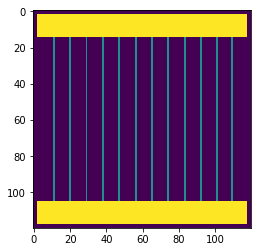

In [11]:
plt.imshow(contactsMask)

## Reduce the shape to 1/4 because of symmetry

In [12]:
nx, ny = contactsMask.shape
# For symmetry arguments (not completely true for the illumination), we can mode just 1/4 of the device and then
# multiply the current by 4
contactsMask = contactsMask[int(nx / 2):, int(ny / 2):]

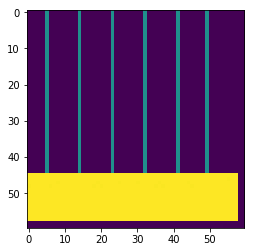

In [13]:
plt.imshow(contactsMask)

## Make illumination

Load the illumination profile. The file can be either a PNG file or a comma sepearted file.

In [14]:
from os.path import join
import os
this_path=os.getcwd()
# both csv and png file are supported.
image_file=join(this_path,'./private_data/',"Illumination profile_20180926.png")
#image_file=join(this_path,"Illumination profile_20180926_random.csv")

In [15]:
def load_illumination(fname):
    _,ext=os.path.splitext(fname)
    ext=ext[1:].lower()
    if (ext=='png'):
        img=imread(fname)
        if img.ndim==3:
            img=img[:,:,0]
    elif (ext=='csv'):
        img=np.loadtxt(fname,delimiter=',')
    return img

In [16]:
img=load_illumination(image_file)

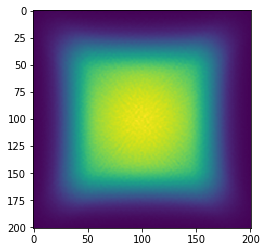

In [17]:
plt.imshow(img)

### Show statistics of the profile

Show histogram of pixel values

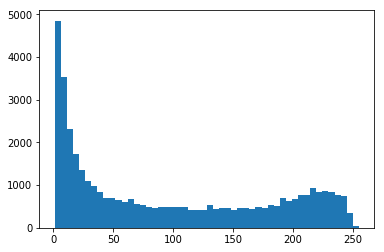

In [18]:
plt.hist(img.ravel(),bins=50)
plt.show()

Total of the pixel value:

In [19]:
value_sum=np.sum(img)
print("The sum of total pixel value: {}".format(value_sum))

The sum of total pixel value: 3840227


In [20]:
pixel_photon_unit=1.1426e11
print("The sum of photon number: {}".format(value_sum*pixel_photon_unit))

The sum of photon number: 4.3878433702e+17


### Reduce the shape to 1/4

In [21]:
illuminationMask=img
illuminationMask=illuminationMask[int(img.shape[0] / 2):, int(img.shape[1] / 2):]

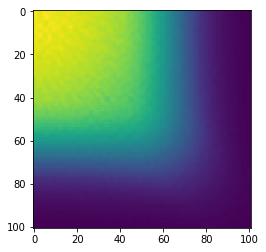

In [22]:
plt.imshow(illuminationMask)

In [23]:
np.max(illuminationMask)

252

In [24]:
illuminationMask.shape

(101, 101)

In [25]:
from scipy.interpolate import interp2d
def resize(image,new_shape):
    xx=np.arange(0,image.shape[0],1)
    yy=np.arange(0,image.shape[1],1)
    image_func=interp2d(xx,yy,image)
    x_new=np.linspace(0,image.shape[0],num=new_shape[0])
    y_new=np.linspace(0,image.shape[1],num=new_shape[1])
    
    resized_image=image_func(x_new,y_new)
    return resized_image

### Downsample the illumination profile
This time we resample the illumination profile and the mask profile to both 50x50 pixels.

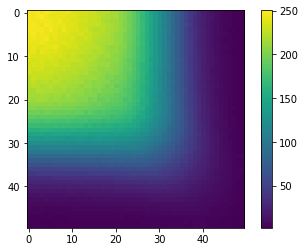

In [26]:
# The size of the image to downsample to
target_shape=(50,50)
resized_illuminationMask=resize(illuminationMask,target_shape)
plt.imshow(resized_illuminationMask)
plt.colorbar()

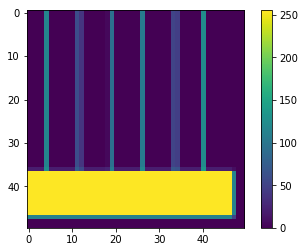

In [27]:
resized_contactsMask=resize(contactsMask,target_shape)
plt.imshow(resized_contactsMask)
plt.colorbar()

In [28]:
resized_contactsMask.max()

255.00000000000006

In [29]:
resized_illuminationMask.max()

250.32653061224485

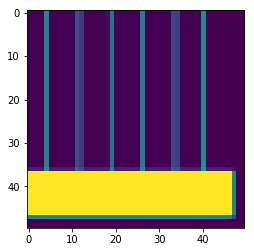

In [30]:
plt.imshow(resized_contactsMask)

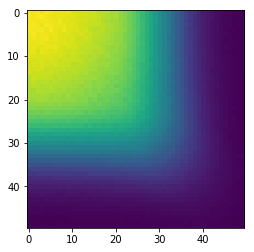

In [31]:
plt.imshow(resized_illuminationMask)

## Set solar cell parameters

In [32]:
# Size of the pixels (m)
Lx = 10e-6
Ly = 10e-6

# Height of the metal fingers (m)
h = 2.2e-6

# Contact resistance (Ohm m2)
Rcontact = 3e-10

# Resistivity metal fingers (Ohm m)
Rline = 2e-8

# Bias (V)
vini = 0
vfin = 3
step = 0.01

T = 298

## Set the parameter of solar cells

This solar cell solver calculates the saturation current J01 and J02 from detail balanced model (assuming 100% aborptivity). Sheet resistance is assigned by the user.

In [33]:
# the solar cell parameters
ingap_cell = Junction(kind='2D', T=T, reff=1, jref=300, Eg=0.66, A=1, R_sheet_top=100, R_sheet_bot=1e-16,
                       R_shunt=1e16, n=3.5)
gaas_cell = Junction(kind='2D', T=T, reff=1, jref=300, Eg=1.4, A=1, R_sheet_top=100, R_sheet_bot=1e-16,
                        R_shunt=1e16, n=3.5)
ge_cell = Junction(kind='2D', T=T, reff=0.5, jref=300, Eg=1.8, A=1, R_sheet_top=100, R_sheet_bot=100,
                        R_shunt=1e16, n=3.5)

# assign which solar cell to use. For example, to use top cell, set my_solar_cell like this:
# my_solar_cell=SolarCell([ingap_cell],T=T)
# For full 3J solar cell, the parameter is like this:
# my_solar_cell=SolarCell([ingap_cell,gaas_cell,ge_cell],T=T)
my_solar_cell = SolarCell([gaas_cell], T=T)

### Set the light source

In [34]:
wl = np.linspace(350, 2000, 301) * 1e-9
light_source = LightSource(source_type='standard', version='AM1.5g', x=wl, output_units='photon_flux_per_m',
                           concentration=100)

options = {'light_iv': True, 'wavelength': wl, 'light_source': light_source}

### Launch the solver

In [35]:
V, I, Vall, Vmet = solve_quasi_3D(my_solar_cell, resized_illuminationMask, resized_contactsMask, options=options, Lx=Lx, Ly=Ly, h=h,
                                  R_back=1e-16, R_contact=Rcontact, R_line=Rline, bias_start=vini, bias_end=vfin,
                                  bias_step=step)

# Since we model 1/4 of the device, we multiply the current by 4
I = I * 4

Solving 1D Solar Cell...
Solving optics of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
... Done!

Solving quasi-3D Solar Cell...
... Done!!


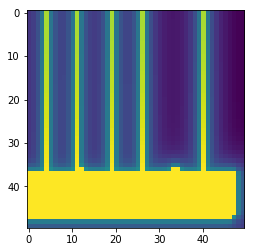

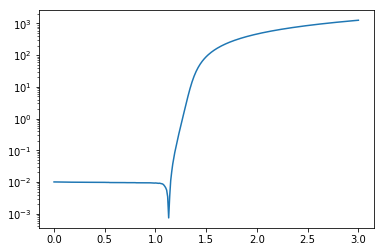

In [36]:
plt.figure(1)
plt.imshow(Vall[:, :, -2, -1])

plt.figure(2)
plt.semilogy(V, abs(I))
plt.show()

## Plot in linear scale

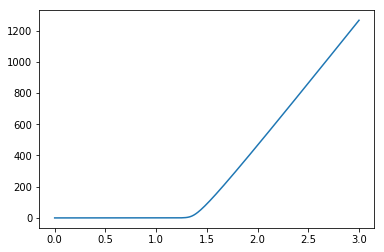

In [37]:
plt.plot(V, I)

Zoom in to negative current

(0, 1.5)

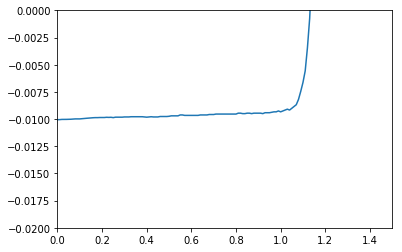

In [38]:
plt.plot(V, I)
plt.ylim([-0.02,0])
plt.xlim([0,1.5])

## Export the I-V characteristics into a CSV file

The result is written into the file ```iv_result.csv```

In [39]:
output_iv=np.vstack([V,I]).T
np.savetxt('iv_result.csv',output_iv,delimiter=',')